In [1]:
# 导入库
import os
import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # 绘图库
import numpy as np
from matplotlib.gridspec import GridSpec  # 自定义子图的网格布局库
from sklearn.impute import SimpleImputer
%matplotlib inline  

warnings.filterwarnings('ignore')    # 忽略警告消息
plt.rcParams['font.sans-serif'] = ['Simhei']   # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
# plt.rcParams['figure.figsize'] = (12.0, 8.0)  # 调整大小,可根据自实际情况进行设置
pd.set_option('display.max_columns', 999)    # 设置数据展示的最大列数和最大行数
pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=np.inf)

# 一、数据查看和分析

## 1.1 加载并查看数据
- 查看数据大小，数据基本特征。
- 数据是否存在缺失值
- 查看数据列、数据类型，以便数据预处理
- 分别查看数值型数据和非数值型数据

In [2]:
# 加载数据，查看数据大小
df_data = pd.read_excel('data_ori.xlsx',index_col=[0])
df_data.shape

(77079, 41)

In [5]:
# datetime64[ns] 转换为 Object 对象
df_data['INCUR_DATE_FROM'] = df_data['INCUR_DATE_FROM'].dt.strftime('%Y-%m-%d')
df_data['INCUR_DATE_TO'] = df_data['INCUR_DATE_TO'].dt.strftime('%Y-%m-%d')
df_data['RCV_DATE'] = df_data['RCV_DATE'].dt.strftime('%Y-%m-%d')

AMT_DAY_USED                  float64
BEN_HEAD                       object
BEN_HEAD_TYPE                  object
BEN_TYPE                       object
CL_OWNER_PAY_AMT              float64
CL_SELF_CAT_PAY_AMT           float64
CL_SOCIAL_PAY_AMT             float64
CL_THIRD_PARTY_PAY_AMT        float64
CLSH_HOSP_CODE                 object
COPAY_PCT                       int64
CRT_USER                       object
CSR_REMARK                     object
CWF_AMT_DAY                     int64
DIAG_CODE                      object
FX_RATE                       float64
INCUR_DATE_FROM                object
INCUR_DATE_TO                  object
INVOICE_RTN_IND                object
KIND_CODE                      object
MBR_NO                          int64
MBR_TYPE                       object
MEMBER_EVENT                   object
NO_OF_YR                        int64
ORG_PRES_AMT                   object
POHO_NO                        object
POLICY_CNT                      int64
PRI_CORR_BRK

## 1.2 查看字符类型数据

In [11]:
suspicious_status = ['CL_LINE_STATUS_PD','CL_LINE_STATUS_RJ','CL_LINE_STATUS_UE']
nomal_status = ['CL_LINE_STATUS_AC']

sum_suspicious = 0
sum_nomal = 0
for i in suspicious_status:
    sum_suspicious += len(df_data['CLSH_HOSP_CODE'][df_data['SCMA_OID_CL_LINE_STATUS'] == i ].value_counts())

# 和欺诈相关的保险公司医院代码总数
print("和欺诈相关的疾病编码的名称总数为：",sum_suspicious)
# 和欺诈无关的保险公司医院代码总数
print("和欺诈无关的疾病编码的名称总数为：",len(df_data['CLSH_HOSP_CODE'][df_data['SCMA_OID_CL_LINE_STATUS'] == 'CL_LINE_STATUS_AC'].value_counts()))

# 保险公司医院代码总数目
print("保险公司医院代码的总数目",len(df_data['CLSH_HOSP_CODE'].value_counts()))

和欺诈相关的疾病编码的名称总数为： 1016
和欺诈无关的疾病编码的名称总数为： 1066
保险公司医院代码的总数目 1205


In [15]:
suspicious_status = ['CL_LINE_STATUS_PD','CL_LINE_STATUS_RJ','CL_LINE_STATUS_UE']
nomal_status = ['CL_LINE_STATUS_AC']

sum_suspicious = 0
sum_nomal = 0
for i in suspicious_status:
    sum_suspicious += len(df_data['DIAG_CODE'][df_data['SCMA_OID_CL_LINE_STATUS'] == i ].value_counts())

# 和欺诈相关的病编码的名称总数
print("和欺诈相关的疾病编码的名称总数为：",sum_suspicious)
# 和欺诈无关的病编码的名称总数
print("和欺诈无关的疾病编码的名称总数为：",len(df_data['DIAG_CODE'][df_data['SCMA_OID_CL_LINE_STATUS'] == 'CL_LINE_STATUS_AC'].value_counts()))

#疾病编码的总数目
print("疾病编码的总数目",len(df_data['DIAG_CODE'].value_counts()))

# 值很多

和欺诈相关的疾病编码的名称总数为： 1045
和欺诈无关的疾病编码的名称总数为： 1625
疾病编码的总数目 1784


# 二、数据探索性分析

## 2.1 处理标签列
- 为了更好地分析各字段和标签列的关系，先处理标签列

In [52]:
# 对标签列进行处理，删除标签为'CL_LINE_STATUS_PV'、'CL_LINE_STATUS_PD'的数据
# df_data_1 = df_data.drop(index=(df_data.loc[df_data['SCMA_OID_CL_LINE_STATUS']=='CL_LINE_STATUS_PV'].index),inplace=False)

drop_value_list = ['CL_LINE_STATUS_PV', 'CL_LINE_STATUS_PD']
drop_idx_list = [i for i, v in df_data.loc[:, 'SCMA_OID_CL_LINE_STATUS'].items() if v in drop_value_list]

df_data = df_data.drop(axis=0, index=drop_idx_list, inplace=False)

CL_LINE_STATUS_AC    64813
CL_LINE_STATUS_RJ    11398
CL_LINE_STATUS_PD      688
CL_LINE_STATUS_PV      180
Name: SCMA_OID_CL_LINE_STATUS, dtype: int64
[90, 286, 419, 559, 560, 585, 859, 1175, 1453, 1533, 1635, 1749, 2376, 2377, 2586, 2821, 2939, 2994, 3019, 3023, 3119, 3452, 3505, 3518, 3530, 3668, 3737, 3783, 3838, 3863, 4295, 4296, 4333, 4389, 4405, 4437, 4438, 4439, 4656, 4920, 4994, 5051, 5054, 5252, 5301, 5302, 5575, 5576, 5579, 5580, 5581, 5635, 5651, 5710, 5871, 5981, 6082, 6169, 6170, 6225, 6272, 6314, 6338, 6486, 6888, 6890, 6891, 6892, 6897, 6929, 6930, 7036, 7148, 7167, 7293, 7460, 7474, 7507, 7521, 7691, 8126, 8149, 8168, 8236, 8257, 8429, 8644, 8806, 9180, 9375, 9712, 9747, 9791, 9881, 9982, 9983, 10013, 10014, 10186, 10553, 10644, 10645, 10737, 10863, 10864, 10913, 10915, 10974, 11079, 11192, 11211, 11521, 11544, 11694, 11787, 11921, 12005, 12006, 12033, 12057, 12234, 12235, 12236, 12279, 12307, 12317, 12398, 12452, 12457, 12459, 12507, 12522, 12523, 12618, 12652, 12672,

In [53]:
# 对标签进行编码(LabelEncoder)
from sklearn.preprocessing import LabelEncoder

y = df_data.loc[:,'SCMA_OID_CL_LINE_STATUS'] # 获得标签列（保存一分后面用得到）

In [54]:
le = LabelEncoder() # 实例化，即创建对象
le = le.fit(y)  # 导入数据
label = le.transform(y) # tranform接口调取结果,也可以直接使用fit_transform接口一步到位

le.classes_ # 属性.classes_查看标签中究竟有多少类别

array(['CL_LINE_STATUS_AC', 'CL_LINE_STATUS_RJ'], dtype=object)

In [56]:
# 把处理好的标签，赋值回原数据矩阵
df_data.loc[:, 'SCMA_OID_CL_LINE_STATUS'] = label

line SCMA_OID_CL_LINE_STATUS:
0     0
1     0
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     1
10    1
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: SCMA_OID_CL_LINE_STATUS, dtype: int32

line SCMA_OID_CL_LINE_STATUS value statistic:
0    64813
1    11398
Name: SCMA_OID_CL_LINE_STATUS, dtype: int64


In [57]:
# 标签列改名为 FRAUD
df_data.rename(columns={'SCMA_OID_CL_LINE_STATUS': 'FRAUD'}, inplace=True)


## 2.2 数据相关性分析

In [61]:
# 查看和福利类型相关的欺诈占比
# groupby 分组方法，by是分组字段，常用为列名，as_index，是否将分组列名作为输出的索引，默认为True，设置为False时相当于加了reset_index功能
# agg 聚合方法，该函数传入的参数为字典，键为变量名，值为对应的聚合函数字符串，sum求和即欺诈的数量，count为总共的条数
df_BEN_TYPE = df_data.groupby('BEN_TYPE', as_index=False).agg({"FRAUD":['sum','mean','count']})

     BEN_TYPE  FRAUD                 
                 sum      mean  count
0       DB-IP      0  0.000000     16
1       DB-OP     13  0.142857     91
2          DT      0  0.000000      2
3       GG-IP      0  0.000000      1
4       GG-OP      2  0.666667      3
5       GS-OP      0  0.000000      1
6      GZCASB      0  0.000000      2
7          IP    266  0.154382   1723
8      IPCASB      6  0.061224     98
9   IPCASB-SS      0  0.000000      5
10       MAIP     15  0.600000     25
11       MAOP     96  0.635762    151
12         MT      4  0.121212     33
13         OP  10873  0.148390  73273
14         VS      0  0.000000      2
15      YW-IP      9  0.236842     38
16  YW-IPCASB      0  0.000000      3
17      YW-OP    114  0.153226    744


- 2）查看欺诈和MBR_TYPE被保险人类型的关系

In [64]:
# 查看和被保险人类型相关的欺诈占比
# 分组，聚合
df_MBR_TYPE = df_data.groupby('MBR_TYPE', as_index=False).agg({"FRAUD":['sum','mean','count']})

    MBR_TYPE FRAUD                 
               sum      mean  count
0  Applicant  9939  0.144595  68737
1      Child  1189  0.182951   6499
2     Others     0  0.000000      9
3    Parents    87  0.630435    138
4     Spouse   183  0.221014    828


- 3） FRAUD 和 COPAY_PCT 病人自付比例之间的关系

In [67]:
# 查看和自付比例相关的欺诈占比
df_COPAY_PCT = df_data.groupby('COPAY_PCT', as_index=False).agg({"FRAUD":['sum','mean','count']})

   COPAY_PCT FRAUD                 
               sum      mean  count
0         20    28  0.201439    139
1         37   152  0.091401   1663
2         40     4  0.102564     39
3         45  2664  0.141304  18853
4         50   922  0.149239   6178
5         55    53  0.035193   1506
6         57    77  0.215686    357
7         60   913  0.127961   7135
8         62    71  0.135755    523
9         65    44  0.192140    229
10        67    20  0.151515    132
11        70   297  0.080032   3711
12        75    95  0.066760   1423
13        80  1798  0.219375   8196
14        85   134  0.082614   1622
15        90  1566  0.250440   6253
16        92    11  0.086614    127
17        95    98  0.125964    778
18       100  2451  0.141292  17347


- 4） FRAUD 和 NO_OF_YR 年数比例之间的关系


In [70]:
# 查看和年数比例相关的欺诈占比
df_NO_OF_YR = df_data.groupby('NO_OF_YR', as_index=False).agg({"FRAUD":['sum','mean','count']})

  NO_OF_YR FRAUD                 
             sum      mean  count
0        1  2229  0.240739   9259
1        2  2365  0.227469  10397
2        3  1966  0.195078  10078
3        4  1626  0.072151  22536
4        5  3212  0.134163  23941


- 5） FRAUD 和 BEN_HEAD 福利项目比例之间的关系


In [73]:
# 查看和福利项目比例相关的欺诈占比
df_BEN_HEAD = df_data.groupby('BEN_HEAD', as_index=False).agg({"FRAUD":['sum','mean','count']})

     BEN_HEAD FRAUD                 
                sum      mean  count
0       100PF     0  0.000000      9
1   100PF-JCF    39  0.062102    628
2   100PF-YPF   152  0.061713   2463
3   100PF-ZCF    47  0.023453   2004
4         10D     0  0.000000      1
5          4D     0  0.000000      1
6        CASB     6  0.059406    101
7       CEZYF     0  0.000000      1
8         CWF     0  0.000000     23
9       F-CWF     3  0.600000      5
10      F-GHF   177  0.327778    540
11     F-HERB     0  0.000000      1
12      F-JCF   836  0.171171   4884
13      F-YLF   125  0.389408    321
14      F-YPF  1677  0.172994   9694
15     F-ZFJC     4  0.097561     41
16     F-ZFYP    53  0.045729   1159
17      F-ZLF   900  0.278552   3231
18      F-ZYF    35  0.388889     90
19     F-ZYJC     0  0.000000      1
20     FLZFYP     0  0.000000      3
21        GHF     2  0.064516     31
22       HERB     5  0.227273     22
23       HVIS     1  0.500000      2
24       INFB     0  0.000000     93
2

- 6） FRAUD 和 PROV_LEVEL 医院等级之间的关系


In [76]:
# 查看和医院等级比例相关的欺诈占比
df_PROV_LEVEL = df_data.groupby('PROV_LEVEL', as_index=False).agg({"FRAUD":['sum','mean','count']})

  PROV_LEVEL FRAUD                 
               sum      mean  count
0         一级  2290  0.383135   5977
1         三级  5907  0.129659  45558
2         二级  2668  0.120877  22072
3         医保   339  0.312731   1084
4        卫生所     1  0.500000      2
5         未知    30  0.588235     51
6        未评级    76  0.128162    593
7        非医保    78  0.346667    225


# 三、数据清洗和特征工程

## 3.1 缺失值处理

In [78]:
type(df_data.isna().sum())  # Series
# df_data.isna().sum()[2]
# 查看缺失值数据类型
print("%-10s"%"存在缺失值字段","%-8s"%"字段数据类型","缺失值个数")
for key,value in df_data.isna().sum().to_dict().items():
    if(value!=0):
        print("%-20s"%key,"%-15s"%df_data[key].dtypes,df_data[key].isna().sum())

存在缺失值字段    字段数据类型   缺失值个数
AMT_DAY_USED         float64         74234
BEN_HEAD_TYPE        object          26120
CLSH_HOSP_CODE       object          9153
CRT_USER             object          1
CSR_REMARK           object          67611
INVOICE_RTN_IND      object          76160
KIND_CODE            object          1726
PROV_CODE            float64         1
PROV_DEPT            object          46959
PROV_LEVEL           object          649
PROV_NAME            object          1
WORKPLACE_NAME       object          16982


In [81]:
# 删除 AMT_DAY_USED 字段(缺失值太多)

df_data = df_data.drop(['AMT_DAY_USED'],axis=1)

# 用中位数填充已使用限额
# df_data.loc[:,'AMT_DAY_USED'] = df_data.loc[:,'AMT_DAY_USED'].fillna(df_data.loc[:,'AMT_DAY_USED'].median())
# df_data.isna().sum()

In [83]:
'''
AMT_DAY_USED         float64         75102   # 已使用日限额                   √
BEN_HEAD_TYPE        object          26492   # 福利项目                       √
CLSH_HOSP_CODE       object          9212    # 保险公司医院代码               √  ×
CSR_REMARK           object          68410   # 杂项 - CSR备注                 √
INVOICE_RTN_IND      object          77028   # 发票资料退回标志               √
KIND_CODE            object          1748    # 险种类型代码                   √ 
PROV_DEPT            object          47683   # 医院科室                       √
PROV_LEVEL           object          649     # 医院等级                       √
WORKPLACE_NAME       object          1742    # 单位                           √  ×


CRT_USER             object          1       # 创建者                         √
PROV_NAME            object          1       # 医疗机构名称                   √  ×
PROV_CODE            float64         1       # 医院代码                       √  ×
'''

'\nAMT_DAY_USED         float64         75102   # 已使用日限额                   √\nBEN_HEAD_TYPE        object          26492   # 福利项目                       √\nCLSH_HOSP_CODE       object          9212    # 保险公司医院代码               √  ×\nCSR_REMARK           object          68410   # 杂项 - CSR备注                 √\nINVOICE_RTN_IND      object          77028   # 发票资料退回标志               √\nKIND_CODE            object          1748    # 险种类型代码                   √ \nPROV_DEPT            object          47683   # 医院科室                       √\nPROV_LEVEL           object          649     # 医院等级                       √\nWORKPLACE_NAME       object          1742    # 单位                           √  ×\n\n\nCRT_USER             object          1       # 创建者                         √\nPROV_NAME            object          1       # 医疗机构名称                   √  ×\nPROV_CODE            float64         1       # 医院代码                       √  ×\n'

In [85]:
# 删除 CSR_REMARK 列
df_data = df_data.drop(['CSR_REMARK'],axis=1)

In [86]:
# 填充其他的缺失值数据（只有一条缺失值的删除整行数据）
# df_data.loc[:,'BEN_HEAD_TYPE ] = df_data.loc[:,'BEN_HEAD_TYPE '].fillna(df_data.loc[:,'BEN_HEAD_TYPE '].median())

print("df_data['BEN_HEAD_TYPE']的值统计：\n%s"%df_data['BEN_HEAD_TYPE'].value_counts())
'''
YPF    33618
JCF    16368
CWF       65
(Unkonwn    26378) 
'''
fill_list = ['BEN_HEAD_TYPE','KIND_CODE','PROV_DEPT']
for i in fill_list:
    df_data.loc[:,i] = df_data.loc[:,i].fillna('Unkonwn')  # Unkonwn    26378


# df_data['INVOICE_RTN_IND'].unique()
# df_data['INVOICE_RTN_IND'].value_counts()
# 8 nan
# 51 Y

df_data.loc[:,'INVOICE_RTN_IND'] = df_data.loc[:,'INVOICE_RTN_IND'].fillna('N')
df_data.loc[:,'INVOICE_RTN_IND'] = df_data.loc[:,'INVOICE_RTN_IND'].replace('nan','N')
# df_data['INVOICE_RTN_IND'].unique()
print("\n填充后 df_data['INVOICE_RTN_IND'] 的值统计:\n%s"%df_data['INVOICE_RTN_IND'].value_counts())


# df_data.isna().sum()

df_data['BEN_HEAD_TYPE']的值统计：
YPF    33887
JCF    16139
CWF       65
Name: BEN_HEAD_TYPE, dtype: int64

填充后 df_data['INVOICE_RTN_IND'] 的值统计:
N    76160
Y       51
Name: INVOICE_RTN_IND, dtype: int64


In [87]:
# 以下字段缺失值数量少，直接删除有缺失值所在行
del_field_null_list = ['CRT_USER','PROV_NAME','PROV_CODE','PROV_LEVEL','CLSH_HOSP_CODE']
for i in del_field_null_list:
    df_data = df_data.dropna(axis=0, subset=[i])
# df_data.isna().sum()


# 删掉(值太多且关联性不大)

del_field_list = ['PROV_NAME','WORKPLACE_NAME']
df_data = df_data.drop(del_field_list,axis=1)

BEN_HEAD                      0
BEN_HEAD_TYPE                 0
BEN_TYPE                      0
CL_OWNER_PAY_AMT              0
CL_SELF_CAT_PAY_AMT           0
CL_SOCIAL_PAY_AMT             0
CL_THIRD_PARTY_PAY_AMT        0
CLSH_HOSP_CODE                0
COPAY_PCT                     0
CRT_USER                      0
CWF_AMT_DAY                   0
DIAG_CODE                     0
FX_RATE                       0
INCUR_DATE_FROM               0
INCUR_DATE_TO                 0
INVOICE_RTN_IND               0
KIND_CODE                     0
MBR_NO                        0
MBR_TYPE                      0
MEMBER_EVENT                  0
NO_OF_YR                      0
ORG_PRES_AMT                  0
POHO_NO                       0
POLICY_CNT                    0
PRI_CORR_BRKR_NAME            0
PROV_CODE                     0
PROV_DEPT                     0
PROV_LEVEL                    0
RCV_DATE                      0
SCMA_OID_BEN_TYPE             0
FRAUD                         0
SCMA_OID

## 3.2 异常值处理

- 异常值分析 → 3σ原则 / 箱型图分析

### 3.2.1 3σ原则分析异常值

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [90]:
# 异常值分析
class ExceptionAnalysis_1:
    def __init__(self):
        pass

    def show_exception_analysis(self,series):
        data = series

        u = data.mean()  # 计算均值
        std = data.std()  # 计算标准差
        stats.kstest(data, 'norm', (u, std))  # kstest，数据分布检验模块，正态性检验或其他数据分布类型，仅适用于连续分布的检验
        print('均值为：%.3f，标准差为：%.3f' % (u, std))
        print('------\n')

        # 正态性检验
        # 绘制数据密度曲线
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(2, 1, 1)
        data.plot(kind='kde', grid=True, style='-k', title='密度曲线')
        plt.axvline(3 * std, color='r', linestyle="--", alpha=0.8)
        plt.axvline(-3 * std, color='r', linestyle="--", alpha=0.8)

        # 筛选出异常值error、剔除异常值之后的数据data_c
        ax2 = fig.add_subplot(2, 1, 2)
        error = data[np.abs(data - u) > 3 * std]  # 大于3σ的异常值数据
        data_c = data[np.abs(data - u) <= 3 * std]  # 小于等于3σ的正常值数据
        print('异常值共%i条\n' % len(error))
        print('异常数据：\n{}'.format(error.index))
        print(len(df_data))
        del_index_list = error.index
        

        # 图表表达
        plt.scatter(data_c.index, data_c, color='k', marker='.', alpha=0.3)
        plt.scatter(error.index, error, color='r', marker='.', alpha=0.5)
        plt.xlim([-100, 100])
        plt.grid()
        
        return del_index_list

In [91]:
# 可研究的数值型字段
digital_features = list(df_data.select_dtypes(include=['float64','int64']).columns)
unrequired_process_features  = ['MBR_NO','POLICY_CNT','PROV_CODE']
digital_features = [item for idx,item in enumerate(digital_features) if item not in unrequired_process_features]

['CL_OWNER_PAY_AMT',
 'CL_SELF_CAT_PAY_AMT',
 'CL_SOCIAL_PAY_AMT',
 'CL_THIRD_PARTY_PAY_AMT',
 'COPAY_PCT',
 'CWF_AMT_DAY',
 'FX_RATE',
 'NO_OF_YR',
 'SUB_AMT',
 'TOTAL_RECEIPT_AMT']

In [92]:
ea1 = ExceptionAnalysis_1()

均值为：41.796，标准差为：1488.765
------

异常值共83条

异常数据：
Int64Index([  337,   338,   345,   768,  1758,  2382,  3571,  3696,  4316,
             4452,  5334,  5447,  5699,  5773,  5968,  7233,  7740,  8566,
             8855,  9571, 10395, 11781, 12979, 14836, 15047, 16343, 17126,
            17508, 17727, 18052, 18132, 18153, 18274, 19158, 19276, 20463,
            21526, 23262, 23759, 24531, 29517, 29583, 30100, 30447, 30801,
            34346, 35909, 36076, 38962, 40760, 42367, 43866, 44019, 44656,
            45351, 49843, 51379, 51627, 52416, 52435, 52551, 54188, 54806,
            55715, 62106, 62440, 62604, 62921, 64445, 65494, 66792, 67806,
            68735, 69596, 69743, 69814, 69900, 71365, 71506, 72492, 73558,
            75176, 76769],
           dtype='int64')
67057
Int64Index([  337,   338,   345,   768,  1758,  2382,  3571,  3696,  4316,
             4452,  5334,  5447,  5699,  5773,  5968,  7233,  7740,  8566,
             8855,  9571, 10395, 11781, 12979, 14836, 15047, 16343, 

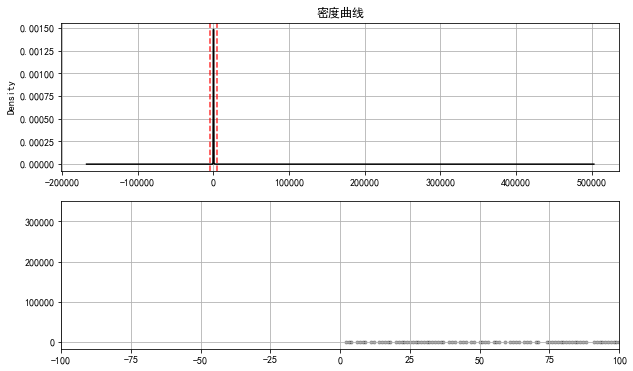

In [94]:
del_index_list = ea1.show_exception_analysis(df_data['CL_OWNER_PAY_AMT'])


df_data.drop(index=del_index_list,inplace=True)


均值为：5.846，标准差为：140.141
------

异常值共99条

异常数据：
Int64Index([  869,  1888,  2017,  3419,  3563,  3828,  4595,  5106,  5209,
             5573,  5813,  6643,  7283,  7386,  8400,  8703,  8771,  8976,
             9443,  9474,  9845, 11796, 11798, 13355, 14006, 14668, 15191,
            15977, 16080, 16086, 16923, 17217, 18204, 18450, 19150, 19241,
            19490, 20499, 20616, 20724, 22028, 22823, 23544, 25667, 25734,
            26592, 27565, 29936, 30060, 30610, 30763, 34728, 35077, 35252,
            35747, 36562, 37447, 38004, 38031, 39341, 39507, 40689, 40778,
            41682, 43212, 44634, 44859, 44880, 45370, 46328, 47870, 51420,
            51553, 52438, 53954, 55115, 56573, 56661, 57754, 58010, 59336,
            59457, 59681, 60319, 60448, 61120, 64031, 64331, 65591, 65632,
            66830, 67933, 70033, 70578, 71361, 71967, 72193, 73980, 76443],
           dtype='int64')
66974
66875


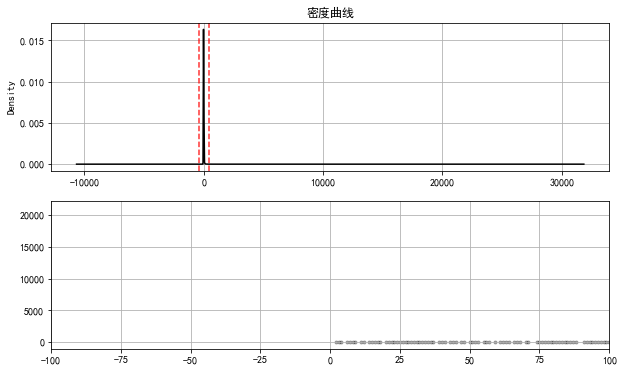

In [95]:
del_index_list = ea1.show_exception_analysis(df_data['CL_SELF_CAT_PAY_AMT'])

df_data.drop(index=del_index_list,inplace=True)


均值为：67.236，标准差为：633.764
------

异常值共461条

异常数据：
Int64Index([   28,   324,   564,   604,   716,   826,   941,  1131,  1151,
             1235,
            ...
            74756, 74799, 75248, 75370, 75975, 76066, 76339, 76370, 76546,
            76841],
           dtype='int64', length=461)
66875


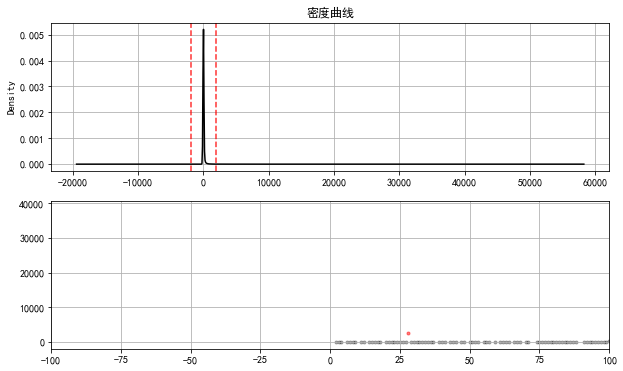

In [96]:
del_index_list = ea1.show_exception_analysis(df_data['CL_SOCIAL_PAY_AMT'])

均值为：0.335，标准差为：36.474
------

异常值共15条

异常数据：
Int64Index([ 2783, 10576, 13977, 14541, 16111, 16705, 26841, 33540, 45432,
            54234, 55311, 56489, 58351, 70220, 74545],
           dtype='int64')
66875
66860


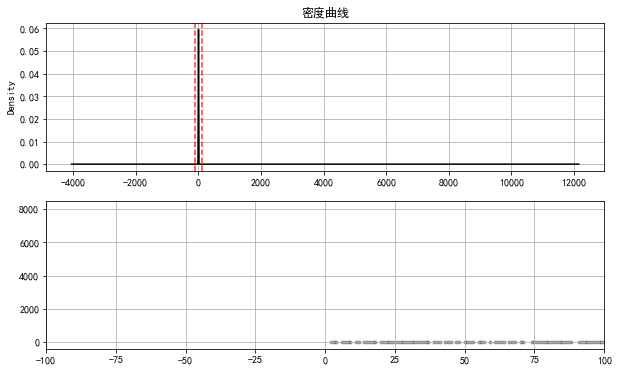

In [97]:
del_index_list = ea1.show_exception_analysis(df_data['CL_THIRD_PARTY_PAY_AMT'])

df_data.drop(index=del_index_list,inplace=True)

均值为：18.588，标准差为：38.234
------

异常值共1098条

异常数据：
Int64Index([  168,   212,   257,   381,   410,   411,   480,   673,   678,
              708,
            ...
            76688, 76772, 76821, 76826, 76932, 76943, 76996, 76997, 77019,
            77049],
           dtype='int64', length=1098)
66860


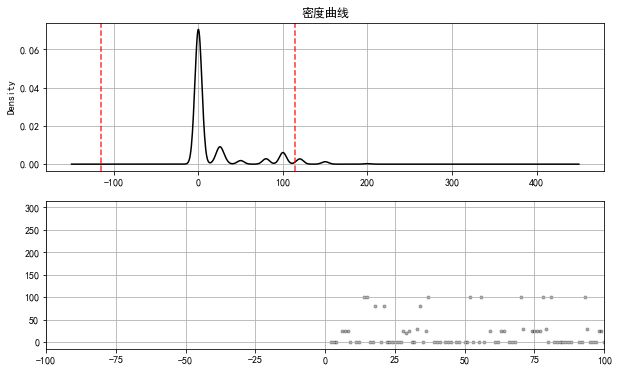

In [98]:
del_index_list = ea1.show_exception_analysis(df_data['CWF_AMT_DAY'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

均值为：3.564，标准差为：1.374
------

异常值共0条

异常数据：
Int64Index([], dtype='int64')
66860


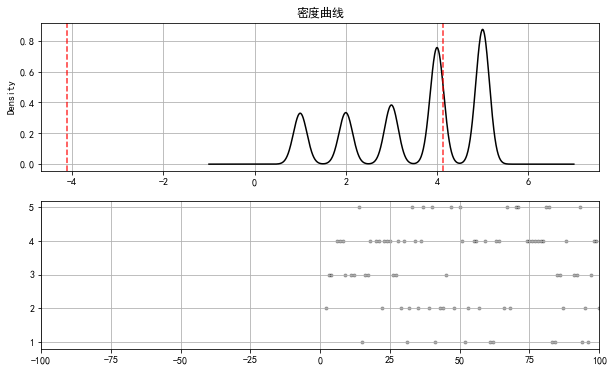

In [99]:
del_index_list = ea1.show_exception_analysis(df_data['NO_OF_YR'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

均值为：220.079，标准差为：922.415
------

异常值共556条

异常数据：
Int64Index([   28,   324,   564,   604,   716,   806,   826,   941,  1131,
             1151,
            ...
            75641, 75642, 75975, 76066, 76265, 76339, 76370, 76546, 76713,
            76841],
           dtype='int64', length=556)
66860


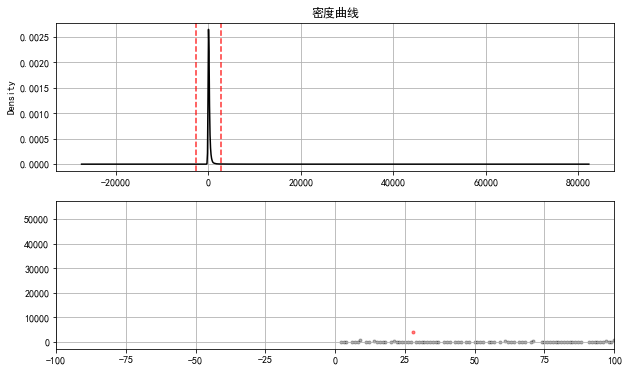

In [100]:
del_index_list = ea1.show_exception_analysis(df_data['SUB_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

均值为：378.317，标准差为：2420.349
------

异常值共530条

异常数据：
Int64Index([  141,   264,   324,   466,   564,   604,   716,  1151,  1235,
             1634,
            ...
            76066, 76264, 76265, 76339, 76546, 76713, 76770, 76771, 76822,
            76841],
           dtype='int64', length=530)
66860


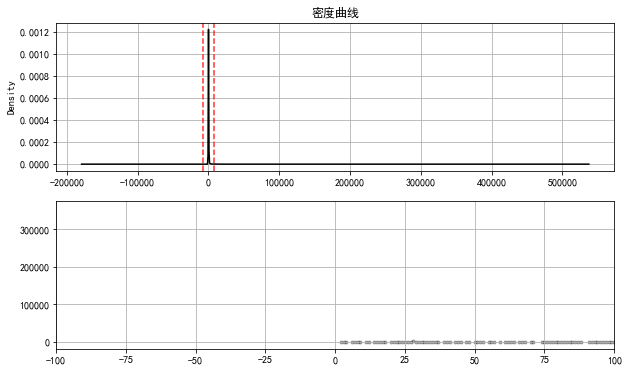

In [101]:
del_index_list = ea1.show_exception_analysis(df_data['TOTAL_RECEIPT_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

In [102]:
print(len(df_data))

66860


### 3.2.2 箱线图分析异常值

In [103]:
class ExceptionAnalysis_2:
    def __init__(self):
        pass
    def show_exception_analysis(self,series):
        # 箱型图分析
        # 箱型图看数据分布情况
        # 以内限为界
        data = series
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(2, 1, 1)
        color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
        data.plot.box(vert=False, grid=True, color=color, ax=ax1, label='样本数据')

        # 基本统计量
        s = data.describe()  # 提供了平均值mean,标准差std,最小值min,最大值max以及1/4,1/2,3/4分位数
        print(s)
        print('------')

        # 计算分位差
        q1 = s['25%']  # 1/4分位数
        q3 = s['75%']  # 3/4分位数
        iqr = q3 - q1
        mi = q1 - 1.5 * iqr  # 分位差下限
        ma = q3 + 1.5 * iqr  # 分位差上限
        print('分位差为：%.3f，下限为：%.3f，上限为：%.3f' % (iqr, mi, ma))
        print('------')

        # 筛选出异常值error、剔除异常值之后的数据data_c
        ax2 = fig.add_subplot(2, 1, 2)
        error = data[(data < mi) | (data > ma)]
        data_c = data[(data >= mi) & (data <= ma)]
        print('异常值共%i条' % len(error))
        print('异常数据：\n{}'.format(error.index))
        del_index_list = error.index
        # df_data.drop(index=del_index_list, inplace=True)

        # 图表表达
        plt.scatter(data_c.index, data_c, color='k', marker='.', alpha=0.3)
        plt.scatter(error.index, error, color='r', marker='.', alpha=0.5)
        plt.xlim([-100, 100])
        plt.grid()
        
        return del_index_list

In [104]:
ea2 = ExceptionAnalysis_2()

count    66860.000000
mean        19.231901
std        142.091472
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max       4430.020000
Name: CL_OWNER_PAY_AMT, dtype: float64
------
分位差为：3.000，下限为：-4.500，上限为：7.500
------
异常值共9497条
异常数据：
Int64Index([    9,    21,    28,    33,    35,    37,    39,    56,    78,
               79,
            ...
            76997, 77009, 77022, 77032, 77039, 77046, 77049, 77052, 77074,
            77077],
           dtype='int64', length=9497)


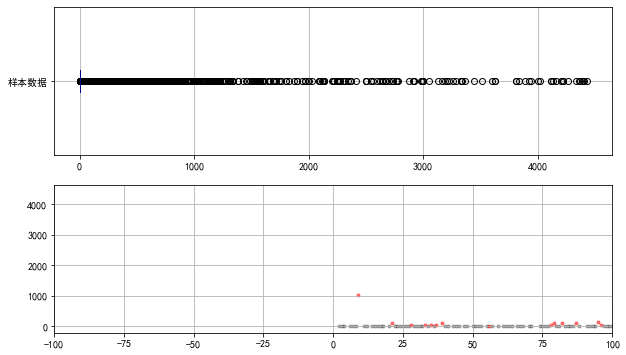

In [105]:
del_index_list = ea2.show_exception_analysis(df_data['CL_OWNER_PAY_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean         3.236690
std         15.615897
min         -0.040000
25%          0.000000
50%          0.000000
75%          0.000000
max        419.400000
Name: CL_SELF_CAT_PAY_AMT, dtype: float64
------
分位差为：0.000，下限为：0.000，上限为：0.000
------
异常值共9554条
异常数据：
Int64Index([   20,    39,    40,    55,    83,    91,    92,    95,   126,
              128,
            ...
            76981, 76985, 77000, 77023, 77053, 77055, 77058, 77062, 77067,
            77070],
           dtype='int64', length=9554)


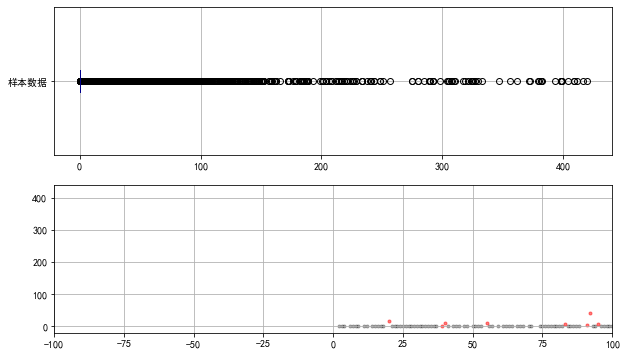

In [106]:
del_index_list = ea2.show_exception_analysis(df_data['CL_SELF_CAT_PAY_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean        66.333350
std        614.488324
min          0.000000
25%          0.000000
50%          0.000000
75%          5.880000
max      29932.340000
Name: CL_SOCIAL_PAY_AMT, dtype: float64
------
分位差为：5.880，下限为：-8.820，上限为：14.700
------
异常值共11124条
异常数据：
Int64Index([   28,    30,    32,    40,    50,    53,    62,    63,    70,
               86,
            ...
            77021, 77028, 77034, 77039, 77042, 77044, 77048, 77050, 77052,
            77053],
           dtype='int64', length=11124)


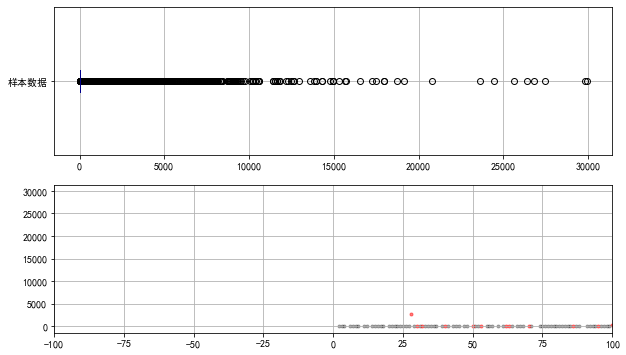

In [107]:
del_index_list = ea2.show_exception_analysis(df_data['CL_SOCIAL_PAY_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean         0.002942
std          0.393453
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         85.450000
Name: CL_THIRD_PARTY_PAY_AMT, dtype: float64
------
分位差为：0.000，下限为：0.000，上限为：0.000
------
异常值共6条
异常数据：
Int64Index([5598, 18415, 18416, 19494, 19757, 56484], dtype='int64')


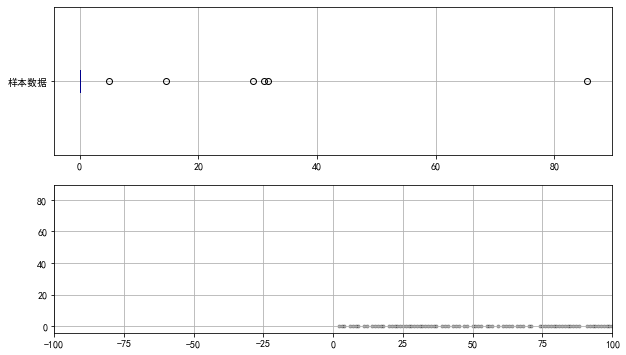

In [108]:
del_index_list = ea2.show_exception_analysis(df_data['CL_THIRD_PARTY_PAY_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean        69.542387
std         22.378852
min         20.000000
25%         45.000000
50%         70.000000
75%         90.000000
max        100.000000
Name: COPAY_PCT, dtype: float64
------
分位差为：45.000，下限为：-22.500，上限为：157.500
------
异常值共0条
异常数据：
Int64Index([], dtype='int64')


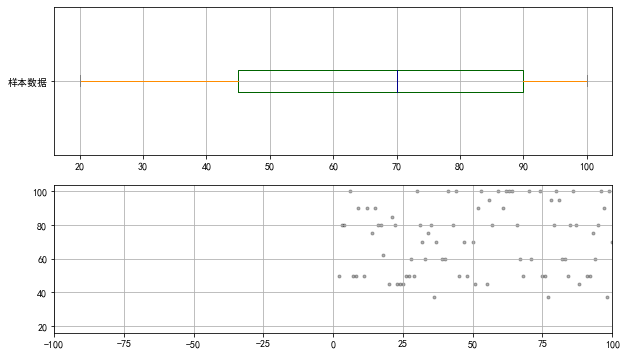

In [109]:
del_index_list = ea2.show_exception_analysis(df_data['COPAY_PCT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean        18.587990
std         38.234467
min          0.000000
25%          0.000000
50%          0.000000
75%         25.000000
max        300.000000
Name: CWF_AMT_DAY, dtype: float64
------
分位差为：25.000，下限为：-37.500，上限为：62.500
------
异常值共9212条
异常数据：
Int64Index([   14,    15,    18,    21,    34,    37,    52,    56,    70,
               78,
            ...
            77019, 77039, 77042, 77043, 77044, 77045, 77048, 77049, 77074,
            77077],
           dtype='int64', length=9212)


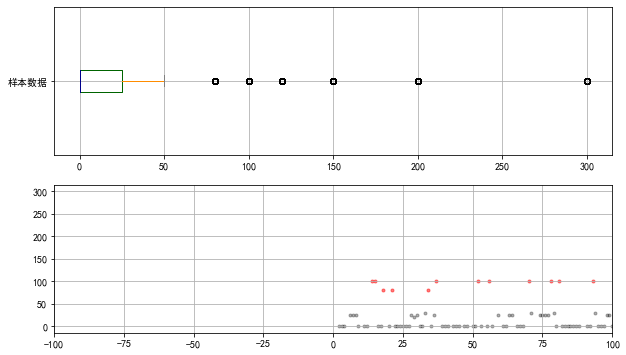

In [110]:
del_index_list = ea2.show_exception_analysis(df_data['CWF_AMT_DAY'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean         3.563521
std          1.374140
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: NO_OF_YR, dtype: float64
------
分位差为：2.000，下限为：0.000，上限为：8.000
------
异常值共0条
异常数据：
Int64Index([], dtype='int64')


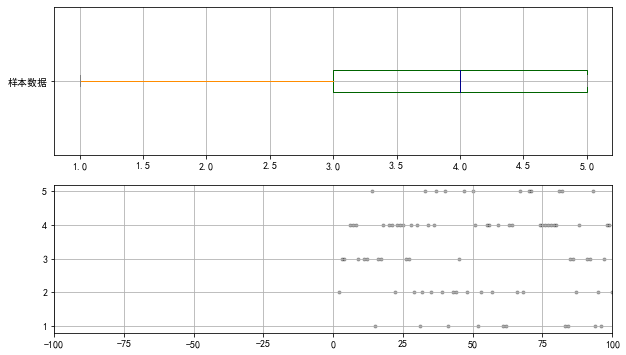

In [111]:
del_index_list = ea2.show_exception_analysis(df_data['NO_OF_YR'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count    66860.000000
mean       220.078685
std        922.415451
min          0.000000
25%         22.000000
50%         63.370000
75%        196.932500
max      54835.110000
Name: SUB_AMT, dtype: float64
------
分位差为：174.933，下限为：-240.399，上限为：459.331
------
异常值共5700条
异常数据：
Int64Index([    9,    28,    71,   100,   112,   139,   158,   195,   243,
              324,
            ...
            76878, 76881, 76895, 76896, 76915, 76935, 76980, 76996, 77007,
            77048],
           dtype='int64', length=5700)


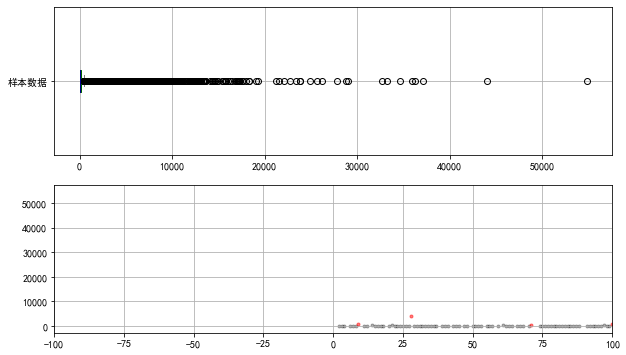

In [112]:
del_index_list = ea2.show_exception_analysis(df_data['SUB_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

count     66860.000000
mean        378.317277
std        2420.348677
min           0.000000
25%          24.000000
50%         111.445000
75%         261.500000
max      358287.960000
Name: TOTAL_RECEIPT_AMT, dtype: float64
------
分位差为：237.500，下限为：-332.250，上限为：617.750
------
异常值共5277条
异常数据：
Int64Index([    9,    28,    71,    80,   100,   107,   141,   158,   264,
              324,
            ...
            76841, 76878, 76881, 76895, 76896, 76915, 76933, 76935, 77048,
            77054],
           dtype='int64', length=5277)


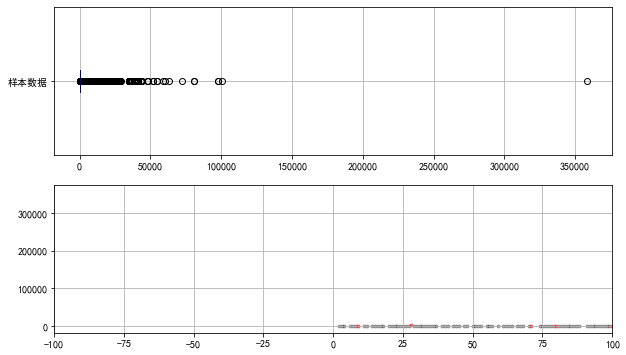

In [113]:
del_index_list = ea2.show_exception_analysis(df_data['TOTAL_RECEIPT_AMT'])

# df_data.drop(index=del_index_list,inplace=True)
# print(len(df_data))

In [114]:
print(len(df_data))

66860


### 3.2.3 其他异常值

In [115]:
# 'POHO_NO'中出现异常值(出现了非数值数据)，删除
df_data['POHO_NO'] = pd.to_numeric(df_data['POHO_NO'], errors='coerce')

# 删除包含NaN值的行
df_data = df_data.dropna()

# 将col1列转换回Object类型
df_data['POHO_NO'] = df_data['POHO_NO'].astype(str)
df_data['POHO_NO'].value_counts()

43000.0     12808
21000.0     10361
275000.0     8077
30000.0      5666
246000.0     3286
19000.0      2881
20000.0      1645
224000.0     1396
333000.0     1368
455000.0     1274
69000.0      1048
121000.0      949
66000.0       652
411000.0      646
356000.0      556
83000.0       511
353000.0      510
280000.0      413
60000.0       389
180000.0      380
91000.0       365
452000.0      350
274000.0      333
64000.0       322
45000.0       300
429000.0      280
427000.0      269
459000.0      267
59000.0       251
387000.0      242
447000.0      237
417000.0      236
385000.0      234
63000.0       229
78000.0       205
37000.0       200
32000.0       192
401000.0      188
82000.0       185
120000.0      184
389000.0      173
36000.0       160
89000.0       154
342000.0      150
316000.0      147
72000.0       146
435000.0      146
334000.0      145
400000.0      143
450000.0      140
430000.0      134
118000.0      134
94000.0       133
456000.0      132
350000.0      132
277000.0  

## 3.3 处理非数值型数据
- 删除一些无关
- 对相关变量进行哑变量处理

### 3.3.1 删除无关列

In [116]:
# 删除以下字段（所有数据该列值都是同一个）
del_field_list = ['MEMBER_EVENT', 'PRI_CORR_BRKR_NAME', 'SCMA_OID_CL_TYPE', 'SCMA_OID_PROD_TYPE', 'INCUR_DATE_FROM','INCUR_DATE_TO']
df_data = df_data.drop(del_field_list, axis=1)
# FX_RATE 字段也删除（所有数据该列值都是同一个）
df_data = df_data.drop(['FX_RATE'], axis=1)
df_data.isna().sum()

BEN_HEAD                      0
BEN_HEAD_TYPE                 0
BEN_TYPE                      0
CL_OWNER_PAY_AMT              0
CL_SELF_CAT_PAY_AMT           0
CL_SOCIAL_PAY_AMT             0
CL_THIRD_PARTY_PAY_AMT        0
CLSH_HOSP_CODE                0
COPAY_PCT                     0
CRT_USER                      0
CWF_AMT_DAY                   0
DIAG_CODE                     0
INVOICE_RTN_IND               0
KIND_CODE                     0
MBR_NO                        0
MBR_TYPE                      0
NO_OF_YR                      0
ORG_PRES_AMT                  0
POHO_NO                       0
POLICY_CNT                    0
PROV_CODE                     0
PROV_DEPT                     0
PROV_LEVEL                    0
RCV_DATE                      0
SCMA_OID_BEN_TYPE             0
FRAUD                         0
SCMA_OID_CL_STATUS            0
SCMA_OID_COUNTRY_TREATMENT    0
SUB_AMT                       0
TOTAL_RECEIPT_AMT             0
dtype: int64

### 3.3.2 哑变量处理


In [117]:
df_data_process = df_data
# 删除某些待定的 无用的列
del_field_list = ['RCV_DATE']
df_data_process = df_data_process.drop(del_field_list,axis=1)





# 医院等级（中文->英文标记）映射（中文映射为英文）
PROV_LEVEL_lever_to_symbol = {
    '一级':'L0',
    '二级':'L1',
    '三级':'L2',
    '未评级':'L3',
    '医保':'L4',
    '非医保':'L5',
    '卫生所':'L6',
    '未知':'L7'
}
df_data_process['PROV_LEVEL'] = df_data_process['PROV_LEVEL'].map(PROV_LEVEL_lever_to_symbol)


# 哑变量处理
'''
pre_dummies_columns = ['BEN_HEAD_TYPE','INVOICE_RTN_IND','MBR_TYPE','POLICY_CNT','PROV_LEVEL','SCMA_OID_BEN_TYPE','SCMA_OID_CL_LINE_STATUS','SCMA_OID_CL_STATUS','SCMA_OID_COUNTRY_TREATMENT']
dummies_columns_prefix = ['BEN_HEAD_TYPE_','INVOICE_RTN_IND_','MBR_TYPE_','POLICY_CNT_','PROV_LEVEL_','SCMA_OID_BEN_TYPE_','SCMA_OID_CL_LINE_STATUS_','SCMA_OID_CL_STATUS_','SCMA_OID_COUNTRY_TREATMENT_']
'''
pre_dummies_columns = ['BEN_HEAD_TYPE','INVOICE_RTN_IND','MBR_TYPE','POLICY_CNT','PROV_LEVEL','SCMA_OID_BEN_TYPE','SCMA_OID_CL_STATUS','SCMA_OID_COUNTRY_TREATMENT']
dummies_columns_prefix = ['BEN_HEAD_TYPE_','INVOICE_RTN_IND_','MBR_TYPE_','POLICY_CNT_','PROV_LEVEL_','SCMA_OID_BEN_TYPE_','SCMA_OID_CL_STATUS_','SCMA_OID_COUNTRY_TREATMENT_']


for idx in range(len(pre_dummies_columns)):
    dummies_item = pd.get_dummies(df_data_process[pre_dummies_columns[idx]],prefix=dummies_columns_prefix[idx])
    df_data_process = pd.concat([df_data_process, dummies_item], axis=1)
    df_data_process.drop( pre_dummies_columns[idx],axis=1, inplace=True)
df_data_process.isna().sum()


BEN_HEAD                                   0
BEN_TYPE                                   0
CL_OWNER_PAY_AMT                           0
CL_SELF_CAT_PAY_AMT                        0
CL_SOCIAL_PAY_AMT                          0
CL_THIRD_PARTY_PAY_AMT                     0
CLSH_HOSP_CODE                             0
COPAY_PCT                                  0
CRT_USER                                   0
CWF_AMT_DAY                                0
DIAG_CODE                                  0
KIND_CODE                                  0
MBR_NO                                     0
NO_OF_YR                                   0
ORG_PRES_AMT                               0
POHO_NO                                    0
PROV_CODE                                  0
PROV_DEPT                                  0
FRAUD                                      0
SUB_AMT                                    0
TOTAL_RECEIPT_AMT                          0
BEN_HEAD_TYPE__CWF                         0
BEN_HEAD_T

### 3.3.3 非数值型相关字段分类后哑变量处理

In [118]:
print(df_data_process['CLSH_HOSP_CODE'].dtypes)
print(set(df_data_process['CLSH_HOSP_CODE'].values))
print(len(df_data_process['CLSH_HOSP_CODE'].value_counts()))
# df_data_process['CLSH_HOSP_CODE'] = df_data_process['CLSH_HOSP_CODE'].astype(str)


import string

# 定义一个字典，将26个字母映射为数字
province_code_dict = {
    'AH': 'AH',
    'BJ': 'BJ',
    'FJ': 'FJ',
    'GD': 'GD',
    'GX': 'GX',
    'GS': 'GS',
    'HB': 'HB',
    'HN': 'HN',
    'HLJ': 'HLJ',
    'JS': 'JS',
    'JX': 'JX',
    'JL': 'JL',
    'LN': 'LN',
    'NM': 'NM',
    'NX': 'NX',
    'QH': 'QH',
    'SD': 'SD',
    'SX': 'SX',
    'SC': 'SC',
    'TW': 'TW',
    'XZ': 'XZ',
    'XN': 'XN',
    'YN': 'YN',
    'ZJ': 'ZJ',
    'CQ': 'CQ',
    'SH': 'SH',
    'TJ': 'TJ',
    'XG': 'XG',
    'AM': 'AM'
}
print(province_code_dict)


# 定义一个函数，根据首字母返回对应的数字
def get_alpha_num(alpha):
    if alpha[2:4] in province_code_dict:  # 按照第1个字符编码
        return province_code_dict[alpha[2:4]]
    else:
        return None

df_data_process['CLSH_HOSP_CODE'] = df_data_process['CLSH_HOSP_CODE'].apply(get_alpha_num)

# 删除空值所在行
df_data_process = df_data_process.dropna(axis=0,subset=['CLSH_HOSP_CODE'])
print(df_data_process.isna().sum())
df_data_process['CLSH_HOSP_CODE'].value_counts()


# 哑变量处理
df_data_process = pd.get_dummies(df_data_process, columns=['CLSH_HOSP_CODE'])
df_data_process

object
{'SHSD00126', 'SHZJ00005', 'SHJS00569', 'SHHN00031', 'SHJS00150', 'SHGD00118', 'SHSHHP024', 'SHGS00002', 'SHGD00286', 'SHGD00491', 'SHSC00036', 'SHGD00023', 'SHSHHK017', 'SHGX00019', 'SHSD00170', 'SHSD00205', 'SHSHQP024', 'SHSHYP020', 'SHSHXH028', 'SHLN00038', 'SHSHFX021', 'SHSHHK010', 'SHGX00062', 'SHSHMH016', 'SHZJ00364', 'SHSHXH015', 'SHBJ00187', 'SHGD00341', 'SHSHJS012', 'SHSHJS024', 'SHGD00140', 'SHGD00342', 'SHGD00160', 'SHJS00248', 'SHGD00088', 'SHSHJA014', 'SHGD00004', 'SHQT00060', 'SHSC00025', 'SHBJ00173', 'SHCQ00002', 'SHSHLW012', 'SHSHBS025', 'SHSHSJ018', 'SHGD00134', 'SHHB00247', 'SHGD00148', 'SHHN00069', 'SHGD00292', 'SHGD00129', 'SHJX00036', 'SHZJ00301', 'SHSD00122', 'SHBJ00137', 'SHSHCN002', 'SHBJ00069', 'SHBJ00409', 'SHSHLW013', 'SHJS00151', 'SHSHPT015', 'SHGD00083', 'SHSHPT024', 'SHSHSJ006', 'SHBJ00197', 'SHTJ00007', 'SHHE00115', 'SHGD00072', 'SHSX00136', 'SHSHXH021', 'SHGD00573', 'SHSHYP005', 'SHSHJD001', 'SHSD00125', 'SHSX00046', 'SHGD00058', 'SHBJ00044', 'SHJ

,BEN_HEAD,BEN_TYPE,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,CL_THIRD_PARTY_PAY_AMT,COPAY_PCT,CRT_USER,CWF_AMT_DAY,DIAG_CODE,KIND_CODE,MBR_NO,NO_OF_YR,ORG_PRES_AMT,POHO_NO,PROV_CODE,PROV_DEPT,FRAUD,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__CWF,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Others,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,POLICY_CNT__3,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L3,PROV_LEVEL__L4,PROV_LEVEL__L5,PROV_LEVEL__L7,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GSOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GZCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIPCAS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,SCMA_OID_COUNTRY_TREATMENT__COUNTRY_086,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ
2,F-YPF,OP,0.00,0.00,0.00,0.0,50,wanglei,0,R21.x00,70P,109823801,2,RMB 49.8,353000.0,24793.0,Unkonwn,1,49.80,49.80,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,S-JCF,OP,0.00,0.00,0.00,0.0,80,yangkang,0,Z32.100,762,99836200,3,RMB 140,275000.0,505.0,Unkonwn,1,140.00,140.00,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,S-JCF,OP,0.00,0.00,0.00,0.0,80,yangkang,0,Z32.100,762,99836200,3,RMB 100,275000.0,505.0,Unkonwn,1,100.00,100.00,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,100PF-YPF,OP,0.00,0.00,4.44,0.0,100,yekaiyong,25,J06.900,7100014,102295100,4,RMB 4.44,21000.0,11294.0,Unkonwn,0,8.88,51.41,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,S-YPF,OP,0.13,0.00,0.00,0.0,50,yekaiyong,25,J06.900,7100014,102295100,4,RMB 1.09,21000.0,11294.0,Unkonwn,0,1.22,51.41,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,S-YPF,OP,0.00,13.76,0.00,0.0,80,wangxm,0,J06.900,70P,107703500,2,RMB 167.96,333000.0,575.0,Unkonwn,0,181.72,181.72,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
77071,S-YPF,OP,0.00,0.00,0.00,0.0,80,chengxia,0,I10.x00I,70P,107803100,2,RMB 74.52,333000.0,13065.0,Unkonwn,0,74.52,74.52,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
77074,F-YPF,OP,19.25,0.00,7.00,0.0,90,yangxuan,100,K59.000,7100014,135168000,1,RMB 174.74,459000.0,11073.0,Unkonwn,0,200.99,200.99,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77076,F-ZLF,OP,0.00,0.00,0.00,0.0,100,wangxm,0,N20.100,70P,135365500,1,RMB 130,246000.0,11402.0,Unkonwn,1,130.00,130.00,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,

In [119]:
# DIAG_CODE

print(df_data_process['DIAG_CODE'].dtypes)
print(set(df_data_process['DIAG_CODE'].values))
print(len(df_data_process['DIAG_CODE'].value_counts()))
df_data_process['DIAG_CODE'] = df_data_process['DIAG_CODE'].astype(str)

import string

# 定义一个字典，将26个字母映射为数字
# alpha_dict = {alpha: num for num, alpha in enumerate(string.ascii_uppercase)}
alpha_dict = {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': 'E', 'F': 'F', 'G': 'G', 'H': 'H', 'I': 'I', 'J': 'J', 'K': 'K', 'L': 'L', 'M': 'M', 'N': 'N', 'O': 'O', 'P': 'P', 'Q': 'Q', 'R': 'R', 'S': 'S', 'T': 'T', 'U': 'U', 'V': 'V', 'W': 'W', 'X': 'X', 'Y': 'Y', 'Z': 'Z'}
print(alpha_dict)


# 定义一个函数，根据首字母返回对应的数字
def get_alpha_num(alpha):
    if alpha[0] in alpha_dict:  # 按照第1个字符编码
        return alpha_dict[alpha[0]]
    else:
        return None


df_data_process['DIAG_CODE'] = df_data_process['DIAG_CODE'].apply(get_alpha_num)

df_data_process['DIAG_CODE'].value_counts()


# 删除空值所在行
df_data_process = df_data_process.dropna(axis=0,subset=['DIAG_CODE'])
print(df_data_process.isna().sum())
df_data_process['DIAG_CODE'].value_counts()


# 哑变量处理
df_data_process = pd.get_dummies(df_data_process, columns=['DIAG_CODE'])
df_data_process

object
{'H91.200', 'C73.x00', 'R63.000', 'I84.900', 'P55.100', 'R04.900', 'G20.x00', 'S82.600', 'T94.102', 'J47.x00', 'S01.803', 'J39.219', 'G36.000', 'K05.100', 'K10.900', 'I49.900', 'Q74.101', 'E02.x00', 'I78.102', 'D38.101', 'N83.200A', 'I70.900A', 'R22.100', 'H66.400', 'K02.400', 'S92.900', 'N40.x00', 'R59.006', 'C22.900', 'Z96.001', 'H01.900', 'D86.100', 'E22.100', 'M67.804', 'B35.400', 'R22.200', 'I69.801', 'L73.900', 'D25.100', 'K12.112', 'P78.300', 'N91.200', 'I74.301', 'R60.001', 'T91.103', 'M79.601', 'M53.301', 'E83.503', 'F06.700', 'K30.x00', 'E21.000', 'R32.x01', 'J18.000', 'E04.000', 'H35.804', 307.201, 'L30.301', 'K46.900D', 'R26.200', 'D37.011', 'J44.802', 'J18.900C', 'S09.900', 'Z51.803', 'N30.900', 'S62.601', 'M77.903', 'R93.203', 'S39.911', 'M79.603', 'E27.900A', 'S36.100', 'Z95.101', 'O03.900', 'N71.902', 'G50.000', 'E16.803', 'I84.201', 'B00.503+', 'S13.601', 'H33.500F', 'N20.000', 'M54.900', 'K11.201', 'K58.900', 'R20.802', 'N00.900', 'S32.801', 'J36.x01', 'M79.801

,BEN_HEAD,BEN_TYPE,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,CL_THIRD_PARTY_PAY_AMT,COPAY_PCT,CRT_USER,CWF_AMT_DAY,KIND_CODE,MBR_NO,NO_OF_YR,ORG_PRES_AMT,POHO_NO,PROV_CODE,PROV_DEPT,FRAUD,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__CWF,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Others,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,POLICY_CNT__3,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L3,PROV_LEVEL__L4,PROV_LEVEL__L5,PROV_LEVEL__L7,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GSOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GZCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIPCAS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,SCMA_OID_COUNTRY_TREATMENT__COUNTRY_086,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Y,DIAG_CODE_Z
2,F-YPF,OP,0.00,0.00,0.00,0.0,50,wanglei,0,70P,109823801,2,RMB 49.8,353000.0,24793.0,Unkonwn,1,49.80,49.80,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,S-JCF,OP,0.00,0.00,0.00,0.0,80,yangkang,0,762,99836200,3,RMB 140,275000.0,505.0,Unkonwn,1,140.00,140.00,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,S-JCF,OP,0.00,0.00,0.00,0.0,80,yangkang,0,762,99836200,3,RMB 100,275000.0,505.0,Unkonwn,1,100.00,100.00,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,100PF-YPF,OP,0.00,0.00,4.44,0.0,100,yekaiyong,25,7100014,102295100,4,RMB 4.44,21000.0,11294.0,Unkonwn,0,8.88,51.41,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,S-YPF,OP,0.13,0.00,0.00,0.0,50,yekaiyong,25,7100014,102295100,4,RMB 1.09,21000.0,11294.0,Unkonwn,0,1.22,51.41,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,S-YPF,OP,0.00,13.76,0.00,0.0,80,wangxm,0,70P,107703500,2,RMB 167.96,333000.0,575.0,Unkonwn,0,181.72,181.72,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77071,S-YPF,OP,0.00,0.00,0.00,0.0,80,chengxia

- 将未处理(保留)的字段放到数据表最后

In [120]:
# MBR_NO
series_tmp = df_data_process['MBR_NO']
df_data_process.drop(['MBR_NO'],axis=1, inplace=True)
df_data_process['MBR_NO'] = series_tmp

In [121]:
# POHO_NO
series_tmp = df_data_process['POHO_NO']
df_data_process.drop(['POHO_NO'],axis=1, inplace=True)
df_data_process['POHO_NO'] = series_tmp

In [122]:
# BEN_HEAD
series_tmp = df_data_process['BEN_HEAD']
df_data_process.drop(['BEN_HEAD'],axis=1, inplace=True)
df_data_process['BEN_HEAD'] = series_tmp

In [123]:
# BEN_TYPE
series_tmp = df_data_process['BEN_TYPE']
df_data_process.drop(['BEN_TYPE'],axis=1, inplace=True)
df_data_process['BEN_TYPE'] = series_tmp

In [124]:
# CRT_USER
series_tmp = df_data_process['CRT_USER']
df_data_process.drop(['CRT_USER'],axis=1, inplace=True)
df_data_process['CRT_USER'] = series_tmp

In [125]:
# KIND_CODE
series_tmp = df_data_process['KIND_CODE']
df_data_process.drop(['KIND_CODE'],axis=1, inplace=True)
df_data_process['KIND_CODE'] = series_tmp

In [126]:
# PROV_CODE
series_tmp = df_data_process['PROV_CODE']
df_data_process.drop(['PROV_CODE'],axis=1, inplace=True)
df_data_process['PROV_CODE'] = series_tmp

In [127]:
# PROV_DEPT
series_tmp = df_data_process['PROV_DEPT']
df_data_process.drop(['PROV_DEPT'],axis=1, inplace=True)
df_data_process['PROV_DEPT'] = series_tmp

## 3.4 数值型数据处理
- 数值变量数据log10X纠偏
- log10X纠偏后标准化
- 区间分段编码

### 3.4.1 数值变量数据log10X纠偏

In [128]:
# 删除 CL_THIRD_PARTY_PAY_AMT (大部分数值都是0)

df_data_process = df_data_process.drop(['CL_THIRD_PARTY_PAY_AMT'],axis=1)

#### 查看CL_OWNER_PAY_AMT数据分布


<AxesSubplot:>

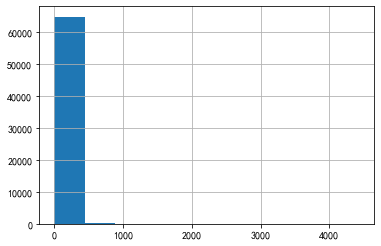

In [129]:
df_data_process['CL_OWNER_PAY_AMT'].hist()   # 直方图

<AxesSubplot:>

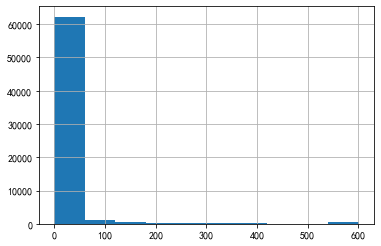

In [130]:
data1 = df_data_process['CL_OWNER_PAY_AMT'].where(df_data_process['CL_OWNER_PAY_AMT']<=600, other=601)
data1.hist()

<AxesSubplot:>

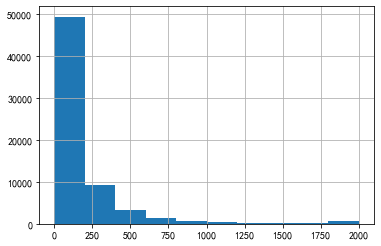

In [131]:
# SUB_AMT 数据偏态严重
data2 = df_data_process['SUB_AMT'].where(df_data_process['SUB_AMT']<=2000, other=2001)
data2.hist()

In [132]:
# 对所有的float64的数据进行数据纠偏操作
# 找出df1中数值型的变量,查看数据的偏度，所有偏度都远大于零，说明数据右偏。
from scipy.stats import skew

numeric_feats = df_data_process.dtypes[df_data_process.dtypes == 'float64'].index
skewed_feats = df_data_process[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats

CL_OWNER_PAY_AMT       18.458283
CL_SELF_CAT_PAY_AMT    12.462423
CL_SOCIAL_PAY_AMT      22.918543
SUB_AMT                21.456283
TOTAL_RECEIPT_AMT      77.191583
PROV_CODE               1.336398
dtype: float64

In [133]:
# 筛选出对所有的float64的数据
# log_features = list(df_data_process.select_dtypes(include=['float64']).columns)
# log_features

# 筛选出对所有的float64的数据
log_features = list(df_data_process.select_dtypes(include=['float64','int64']).columns)
unrequired_process_features  = ['MBR_NO','POLICY_CNT','PROV_CODE']
log_features = [item for idx,item in enumerate(log_features) if item not in unrequired_process_features]
log_features

['CL_OWNER_PAY_AMT',
 'CL_SELF_CAT_PAY_AMT',
 'CL_SOCIAL_PAY_AMT',
 'COPAY_PCT',
 'CWF_AMT_DAY',
 'NO_OF_YR',
 'SUB_AMT',
 'TOTAL_RECEIPT_AMT']

In [134]:
# 对这些偏度大的金额数据进行Log10()转换的纠偏处理

for i in log_features:
    df_data_process[i] = df_data_process[i].map(lambda x: np.log10(x) if x>0 else 0)

df_data_process[log_features].describe()

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,SUB_AMT,TOTAL_RECEIPT_AMT
count,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000
mean,0.342190,0.156283,0.421110,1.816951,0.459407,0.507799,1.786650,1.969199
std,0.621765,0.427869,0.787138,0.144741,0.783105,0.225028,0.679541,0.652403
min,-2.000000,-2.000000,-1.397940,1.301030,0.000000,0.000000,-2.000000,-2.000000
25%,0.000000,0.000000,0.000000,1.653213,0.000000,0.477121,1.342423,1.380211
50%,0.000000,0.000000,0.000000,1.792392,0.000000,0.602060,1.797129,2.043951
75%,0.477121,0.000000,0.778151,1.954243,1.397940,0.698970,2.291358,2.414957
max,3.646406,2.622628,4.476141,2.000000,2.477121,0.698970,4.739059,5.554232


In [135]:
# 查看用log10X进行纠偏后数据的偏度，因为数据严重右偏的得到纠偏后还是有些偏态的。但是相比之前的数据状态已经调整了很多。
skewed_feats_afterlog = df_data_process[log_features].apply(lambda x: skew(x.dropna()))
skewed_feats_afterlog

CL_OWNER_PAY_AMT       1.963055
CL_SELF_CAT_PAY_AMT    2.562279
CL_SOCIAL_PAY_AMT      1.821740
COPAY_PCT             -0.084086
CWF_AMT_DAY            1.202300
NO_OF_YR              -1.238908
SUB_AMT               -0.140063
TOTAL_RECEIPT_AMT     -0.044981
dtype: float64

### 3.4.2 数据标准化
#### 对log纠偏的数值型变量float64，进行数据标准化操作：MinMaxScaler¶

In [136]:
# 对float64相关的数值变量进行区间缩放数据标准化处理(0-1)
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()   # 归一化[0,1]

df_data_process[log_features] = trans.fit_transform(df_data_process[log_features])
df_data_process[log_features].describe()

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,SUB_AMT,TOTAL_RECEIPT_AMT
count,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000,65359.000000
mean,0.414811,0.466462,0.309674,0.738116,0.185460,0.726497,0.561896,0.525427
std,0.110117,0.092560,0.134002,0.207078,0.316135,0.321942,0.100836,0.086363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.354208,0.432654,0.237984,0.503859,0.000000,0.682606,0.495978,0.447459
50%,0.354208,0.432654,0.237984,0.702980,0.000000,0.861353,0.563451,0.535323
75%,0.438708,0.432654,0.370456,0.934536,0.564341,1.000000,0.636789,0.584435
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 对 ORG_PRES_AMT 进行换算，变为数值

In [137]:
# ORG_PRES_AMT

print(df_data['ORG_PRES_AMT'].value_counts(),"\n\n")
print(df_data['ORG_PRES_AMT'].sort_values(),"\n")

def replace_of_squares(x):
    if x.startswith("RMB "):
        x = x.lstrip("RMB ")
        
        return float(x)
    else:
        x = x.lstrip("USD ")
        return float(x)*7

df_data_process['ORG_PRES_AMT'] = df_data_process['ORG_PRES_AMT'].apply(replace_of_squares)
print(df_data_process['ORG_PRES_AMT'].sort_values())
df_data_process = df_data_process.dropna(axis=0,subset=['ORG_PRES_AMT'])


# 显示结果
print(df_data_process.isna().sum())
df_data_process['ORG_PRES_AMT'].value_counts()



# 标准化处理(0-1)
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()   # 归一化[0,1]

df_data_process[['ORG_PRES_AMT']] = trans.fit_transform(df_data_process[['ORG_PRES_AMT']])
df_data_process[['ORG_PRES_AMT']].describe()

RMB 16        5231
RMB 0         4241
RMB 13        4170
RMB 12         770
RMB 8          582
              ... 
RMB 302.54       1
RMB 52.4         1
RMB 629.32       1
RMB 263.82       1
RMB 318.98       1
Name: ORG_PRES_AMT, Length: 21184, dtype: int64 


21490        RMB -.6
59575    RMB -320.82
35644        RMB .01
70968        RMB .01
52586        RMB .02
            ...     
2030      RMB 995.45
1248      RMB 997.09
74022      RMB 997.7
76546      RMB 998.4
47278     RMB 998.76
Name: ORG_PRES_AMT, Length: 66738, dtype: object 

59575     -320.82
21490       -0.60
38743        0.00
5436         0.00
38766        0.00
           ...   
65327    11987.30
42598    13064.61
54643    19803.78
31420    29334.12
48393    29947.67
Name: ORG_PRES_AMT, Length: 65359, dtype: float64
CL_OWNER_PAY_AMT                           0
CL_SELF_CAT_PAY_AMT                        0
CL_SOCIAL_PAY_AMT                          0
COPAY_PCT                                  0
CWF_AMT_DAY                   

,ORG_PRES_AMT
count,65359.000000
mean,0.014868
std,0.011491
min,0.000000
25%,0.011029
50%,0.011947
75%,0.015423
max,1.000000


## 5.特征选择

## 5.1 包装法特征选择（wrapper）

In [138]:
df_data_process.dtypes

CL_OWNER_PAY_AMT                           float64
CL_SELF_CAT_PAY_AMT                        float64
CL_SOCIAL_PAY_AMT                          float64
COPAY_PCT                                  float64
CWF_AMT_DAY                                float64
NO_OF_YR                                   float64
ORG_PRES_AMT                               float64
FRAUD                                        int32
SUB_AMT                                    float64
TOTAL_RECEIPT_AMT                          float64
BEN_HEAD_TYPE__CWF                           uint8
BEN_HEAD_TYPE__JCF                           uint8
BEN_HEAD_TYPE__Unkonwn                       uint8
BEN_HEAD_TYPE__YPF                           uint8
INVOICE_RTN_IND__N                           uint8
INVOICE_RTN_IND__Y                           uint8
MBR_TYPE__Applicant                          uint8
MBR_TYPE__Child                              uint8
MBR_TYPE__Others                             uint8
MBR_TYPE__Parents              

In [139]:
pre_selection_columns = df_data_process.dtypes.index[0:-8]

In [140]:
# 训练数据
X = df_data_process[pre_selection_columns].drop('FRAUD',axis=1)
X

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,ORG_PRES_AMT,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__CWF,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Others,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,POLICY_CNT__3,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L3,PROV_LEVEL__L4,PROV_LEVEL__L5,PROV_LEVEL__L7,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GSOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_GZCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIPCAS,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,SCMA_OID_COUNTRY_TREATMENT__COUNTRY_086,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Y,DIAG_CODE_Z
2,0.354208,0.432654,0.237984,0.569323,0.000000,0.430677,0.012244,0.548627,0.489425,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.015224,0.615238,0.548848,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.013903,0.593555,0.529505,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.354208,0.432654,0.348195,1.000000,0.564341,0.861353,0.010746,0.437511,0.491254,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.197284,0.432654,0.237984,0.569323,0.564341,0.861353,0.010635,0.309592,0.491254,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,0.354208,0.678968,0.237984,0.861353,0.000000,0.430677,0.016148,0.632047,0.563843,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77071,0.354208,0.432654,0.237984,0.861353,0.000000,0.430677,0.013061,0.574601,0.512596,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77074,0.581685,0.432654,0.381853,0.934536,0.807389,0.000000,0.016372,0.638542,0.569638,0,0,0

In [141]:
# 标签列
y = df_data_process['FRAUD']

In [142]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC


RFC_ = RFC(n_estimators =10,random_state=0)
selector = RFE(RFC_, n_features_to_select=80, step=50).fit(X, y)

print(selector.support_.sum()) #.support_：返回所有的特征的是否最后被选中的布尔矩阵
print(selector.ranking_ )# .ranking_返回特征的按数次迭代中综合重要性的排名

X_wrapper = selector.transform(X)
cross_val_score(RFC_,X_wrapper,y,cv=5).mean() # score得分为0.93797619

80
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 2 1 2 2 2 1 1 2
 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1]


0.9235605660713585

In [143]:
df_data_selected_features = X.iloc[:, selector.support_]
df_data_selected_features
# X_wrapper

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,ORG_PRES_AMT,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L4,PROV_LEVEL__L5,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Z
2,0.354208,0.432654,0.237984,0.569323,0.000000,0.430677,0.012244,0.548627,0.489425,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.015224,0.615238,0.548848,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.013903,0.593555,0.529505,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.354208,0.432654,0.348195,1.000000,0.564341,0.861353,0.010746,0.437511,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.197284,0.432654,0.237984,0.569323,0.564341,0.861353,0.010635,0.309592,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,0.354208,0.678968,0.237984,0.861353,0.000000,0.430677,0.016148,0.632047,0.563843,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
77071,0.354208,0.432654,0.237984,0.861353,0.000000,0.430677,0.013061,0.574601,0.512596,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77074,0.581685,0.432654,0.381853,0.934536,0.807389,0.000000,0.016372,0.638542,0.569638,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
77076,0.354208,0.432654,0.237984,1.000000,0.000000,0.000000,0.014894,0.610463,0.544588,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


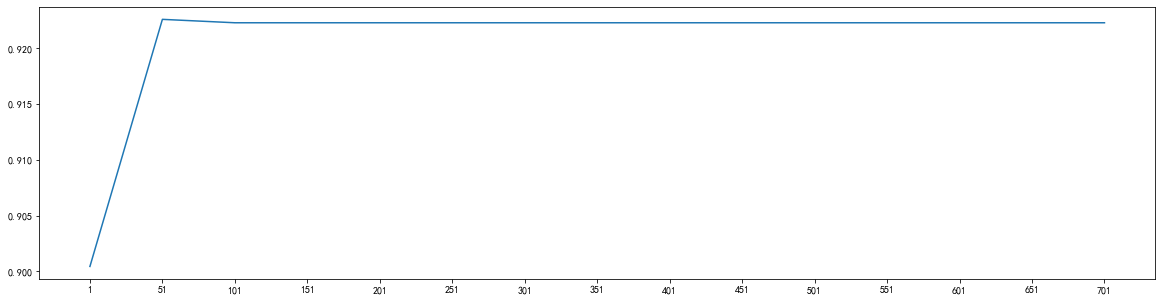

In [144]:
# 对包装法画学习曲线,找到最优特征参数
score = []
for i in range(1,751,50):
    X_wrapper = RFE(RFC_,n_features_to_select=i, step=50).fit_transform(X,y)
    once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,751,50),score)
plt.xticks(range(1,751,50))
plt.show()

In [145]:
# 拼起来

In [146]:
df_data_selected_features.columns

Index(['CL_OWNER_PAY_AMT', 'CL_SELF_CAT_PAY_AMT', 'CL_SOCIAL_PAY_AMT',
       'COPAY_PCT', 'CWF_AMT_DAY', 'NO_OF_YR', 'ORG_PRES_AMT', 'SUB_AMT',
       'TOTAL_RECEIPT_AMT', 'BEN_HEAD_TYPE__JCF', 'BEN_HEAD_TYPE__Unkonwn',
       'BEN_HEAD_TYPE__YPF', 'INVOICE_RTN_IND__N', 'INVOICE_RTN_IND__Y',
       'MBR_TYPE__Applicant', 'MBR_TYPE__Child', 'MBR_TYPE__Parents',
       'MBR_TYPE__Spouse', 'POLICY_CNT__1', 'POLICY_CNT__2', 'PROV_LEVEL__L0',
       'PROV_LEVEL__L1', 'PROV_LEVEL__L2', 'PROV_LEVEL__L4', 'PROV_LEVEL__L5',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP',
       'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP',
       'SCMA_OID_CL_STATUS__CL_STATUS_FC', 'SCMA_OID_CL_STA

In [148]:
concat_columns = df_data_process.dtypes.index[-8:]
df_data_process = pd.concat([df_data_selected_features,df_data_process[concat_columns],df_data_process['FRAUD']],axis=1)

In [149]:
df_data_process

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,ORG_PRES_AMT,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L4,PROV_LEVEL__L5,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Z,MBR_NO,POHO_NO,BEN_HEAD,BEN_TYPE,CRT_USER,KIND_CODE,PROV_CODE,PROV_DEPT,FRAUD
2,0.354208,0.432654,0.237984,0.569323,0.000000,0.430677,0.012244,0.548627,0.489425,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,109823801,353000.0,F-YPF,OP,wanglei,70P,24793.0,Unkonwn,1
3,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.015224,0.615238,0.548848,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,99836200,275000.0,S-JCF,OP,yangkang,762,505.0,Unkonwn,1
4,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.013903,0.593555,0.529505,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,99836200,275000.0,S-JCF,OP,yangkang,762,505.0,Unkonwn,1
6,0.354208,0.432654,0.348195,1.000000,0.564341,0.861353,0.010746,0.437511,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,102295100,21000.0,100PF-YPF,OP,yekaiyong,7100014,11294.0,Unkonwn,0
7,0.197284,0.432654,0.237984,0.569323,0.564341,0.861353,0.010635,0.309592,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,102295100,21000.0,S-YPF,OP,yekaiyong,7100014,11294.0,Unkonwn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,0.354208,0.678968,0.237984,0.861353,0.000000,0.430677,0.016148,0.632047,0.563843,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,107703500,333000.0,S-YPF,OP,wangxm,70P,575.0,Unkonwn,0
77071,0.354208,0.432654,0.237984,0.861353,0.000000,0.430677,0.013061,0.574601,0.512596,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,107803100,333000.0,S-YPF,OP,chengxia,70P,13065.0,Unkonwn,0
77074,0.581685,0.432654,0.381853,0.934536,0.807389,0.000000,0.016372,0.638542,0.569638,0,0,1,1,0,1,0,0

## 降维

- class sklearn.decomposition.PCA (n_components=None, copy=True, whiten=False, svd_solver=’auto’, tol=0.0,iterated_power=’auto’, random_state=None)

- n_components是我们降维后需要的维度，即降维后需要保留的特征数量。取太小，特征向量无法表达原数据的信息；如果取值大，起不到降维的效果。

- 可以先从我们的降维目标说起：如果我们希望可视化一组数据来观察数据分布，通常是把数据降到二维，即n_components的取值为2。


In [150]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [151]:
df_data_selected_features

,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,ORG_PRES_AMT,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L4,PROV_LEVEL__L5,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Z
2,0.354208,0.432654,0.237984,0.569323,0.000000,0.430677,0.012244,0.548627,0.489425,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.015224,0.615238,0.548848,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.013903,0.593555,0.529505,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.354208,0.432654,0.348195,1.000000,0.564341,0.861353,0.010746,0.437511,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.197284,0.432654,0.237984,0.569323,0.564341,0.861353,0.010635,0.309592,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77070,0.354208,0.678968,0.237984,0.861353,0.000000,0.430677,0.016148,0.632047,0.563843,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
77071,0.354208,0.432654,0.237984,0.861353,0.000000,0.430677,0.013061,0.574601,0.512596,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77074,0.581685,0.432654,0.381853,0.934536,0.807389,0.000000,0.016372,0.638542,0.569638,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
77076,0.354208,0.432654,0.237984,1.000000,0.000000,0.000000,0.014894,0.610463,0.544588,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [152]:
# 提取数据
X  = df_data_selected_features

In [153]:
print(X.shape)
import pandas as pd
pd.DataFrame(X).head()

(65359, 80)


,CL_OWNER_PAY_AMT,CL_SELF_CAT_PAY_AMT,CL_SOCIAL_PAY_AMT,COPAY_PCT,CWF_AMT_DAY,NO_OF_YR,ORG_PRES_AMT,SUB_AMT,TOTAL_RECEIPT_AMT,BEN_HEAD_TYPE__JCF,BEN_HEAD_TYPE__Unkonwn,BEN_HEAD_TYPE__YPF,INVOICE_RTN_IND__N,INVOICE_RTN_IND__Y,MBR_TYPE__Applicant,MBR_TYPE__Child,MBR_TYPE__Parents,MBR_TYPE__Spouse,POLICY_CNT__1,POLICY_CNT__2,PROV_LEVEL__L0,PROV_LEVEL__L1,PROV_LEVEL__L2,PROV_LEVEL__L4,PROV_LEVEL__L5,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP,SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP,SCMA_OID_CL_STATUS__CL_STATUS_FC,SCMA_OID_CL_STATUS__CL_STATUS_PC,SCMA_OID_CL_STATUS__CL_STATUS_PV,CLSH_HOSP_CODE_AH,CLSH_HOSP_CODE_BJ,CLSH_HOSP_CODE_CQ,CLSH_HOSP_CODE_FJ,CLSH_HOSP_CODE_GD,CLSH_HOSP_CODE_GS,CLSH_HOSP_CODE_GX,CLSH_HOSP_CODE_HB,CLSH_HOSP_CODE_HN,CLSH_HOSP_CODE_JL,CLSH_HOSP_CODE_JS,CLSH_HOSP_CODE_JX,CLSH_HOSP_CODE_LN,CLSH_HOSP_CODE_SC,CLSH_HOSP_CODE_SD,CLSH_HOSP_CODE_SH,CLSH_HOSP_CODE_SX,CLSH_HOSP_CODE_TJ,CLSH_HOSP_CODE_YN,CLSH_HOSP_CODE_ZJ,DIAG_CODE_A,DIAG_CODE_B,DIAG_CODE_C,DIAG_CODE_D,DIAG_CODE_E,DIAG_CODE_F,DIAG_CODE_G,DIAG_CODE_H,DIAG_CODE_I,DIAG_CODE_J,DIAG_CODE_K,DIAG_CODE_L,DIAG_CODE_M,DIAG_CODE_N,DIAG_CODE_O,DIAG_CODE_P,DIAG_CODE_Q,DIAG_CODE_R,DIAG_CODE_S,DIAG_CODE_T,DIAG_CODE_W,DIAG_CODE_X,DIAG_CODE_Z
2,0.354208,0.432654,0.237984,0.569323,0.000000,0.430677,0.012244,0.548627,0.489425,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.015224,0.615238,0.548848,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.354208,0.432654,0.237984,0.861353,0.000000,0.682606,0.013903,0.593555,0.529505,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.354208,0.432654,0.348195,1.000000,0.564341,0.861353,0.010746,0.437511,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.197284,0.432654,0.237984,0.569323,0.564341,0.861353,0.010635,0.309592,0.491254,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [154]:
# 调用PCA
pca = PCA(n_components=20) # 实例化
pca = pca.fit(X) #拟合模型

X_dr = pca.transform(X) # 获取新 X_dr
# X_dr = PCA(2).fit_transform(X)

X_dr.shape

(65359, 20)

In [155]:
# X_dr

In [156]:
df_data_process.dtypes

CL_OWNER_PAY_AMT                          float64
CL_SELF_CAT_PAY_AMT                       float64
CL_SOCIAL_PAY_AMT                         float64
COPAY_PCT                                 float64
CWF_AMT_DAY                               float64
NO_OF_YR                                  float64
ORG_PRES_AMT                              float64
SUB_AMT                                   float64
TOTAL_RECEIPT_AMT                         float64
BEN_HEAD_TYPE__JCF                          uint8
BEN_HEAD_TYPE__Unkonwn                      uint8
BEN_HEAD_TYPE__YPF                          uint8
INVOICE_RTN_IND__N                          uint8
INVOICE_RTN_IND__Y                          uint8
MBR_TYPE__Applicant                         uint8
MBR_TYPE__Child                             uint8
MBR_TYPE__Parents                           uint8
MBR_TYPE__Spouse                            uint8
POLICY_CNT__1                               uint8
POLICY_CNT__2                               uint8


In [157]:
df_data_premodel = df_data_process

In [158]:
df_data.shape

(66738, 30)

In [159]:
df_data_premodel.shape

(65359, 89)

# 四、数据保存为建模使用

In [160]:
df_data_premodel.to_csv('df_data_premodel_test.csv',index=False)

In [161]:
df_data_premodel.shape

(65359, 89)

In [162]:
list(df_data_premodel.columns)

['CL_OWNER_PAY_AMT',
 'CL_SELF_CAT_PAY_AMT',
 'CL_SOCIAL_PAY_AMT',
 'COPAY_PCT',
 'CWF_AMT_DAY',
 'NO_OF_YR',
 'ORG_PRES_AMT',
 'SUB_AMT',
 'TOTAL_RECEIPT_AMT',
 'BEN_HEAD_TYPE__JCF',
 'BEN_HEAD_TYPE__Unkonwn',
 'BEN_HEAD_TYPE__YPF',
 'INVOICE_RTN_IND__N',
 'INVOICE_RTN_IND__Y',
 'MBR_TYPE__Applicant',
 'MBR_TYPE__Child',
 'MBR_TYPE__Parents',
 'MBR_TYPE__Spouse',
 'POLICY_CNT__1',
 'POLICY_CNT__2',
 'PROV_LEVEL__L0',
 'PROV_LEVEL__L1',
 'PROV_LEVEL__L2',
 'PROV_LEVEL__L4',
 'PROV_LEVEL__L5',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_DBOP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_IPCASB',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAIP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MAOP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_MT',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_OP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWIP',
 'SCMA_OID_BEN_TYPE__BENEFIT_TYPE_YWOP',
 'SCMA_OID_CL_STATUS__CL_STATUS_FC',
 'SCMA_OID_CL_STATUS__CL_STATUS_PC',
 'SCMA_OID_CL_STATUS__CL_STATUS_PV',
 'CLSH_HOSP_CODE_AH',
 'CL

In [163]:
df_data_premodel.dtypes

CL_OWNER_PAY_AMT                          float64
CL_SELF_CAT_PAY_AMT                       float64
CL_SOCIAL_PAY_AMT                         float64
COPAY_PCT                                 float64
CWF_AMT_DAY                               float64
NO_OF_YR                                  float64
ORG_PRES_AMT                              float64
SUB_AMT                                   float64
TOTAL_RECEIPT_AMT                         float64
BEN_HEAD_TYPE__JCF                          uint8
BEN_HEAD_TYPE__Unkonwn                      uint8
BEN_HEAD_TYPE__YPF                          uint8
INVOICE_RTN_IND__N                          uint8
INVOICE_RTN_IND__Y                          uint8
MBR_TYPE__Applicant                         uint8
MBR_TYPE__Child                             uint8
MBR_TYPE__Parents                           uint8
MBR_TYPE__Spouse                            uint8
POLICY_CNT__1                               uint8
POLICY_CNT__2                               uint8


In [164]:
df_data_premodel.isna().sum()

CL_OWNER_PAY_AMT                          0
CL_SELF_CAT_PAY_AMT                       0
CL_SOCIAL_PAY_AMT                         0
COPAY_PCT                                 0
CWF_AMT_DAY                               0
NO_OF_YR                                  0
ORG_PRES_AMT                              0
SUB_AMT                                   0
TOTAL_RECEIPT_AMT                         0
BEN_HEAD_TYPE__JCF                        0
BEN_HEAD_TYPE__Unkonwn                    0
BEN_HEAD_TYPE__YPF                        0
INVOICE_RTN_IND__N                        0
INVOICE_RTN_IND__Y                        0
MBR_TYPE__Applicant                       0
MBR_TYPE__Child                           0
MBR_TYPE__Parents                         0
MBR_TYPE__Spouse                          0
POLICY_CNT__1                             0
POLICY_CNT__2                             0
PROV_LEVEL__L0                            0
PROV_LEVEL__L1                            0
PROV_LEVEL__L2                  

# 数据编码标准化

In [ ]:
# 删除某些待定的 ########################################################################################################################
# del_field_list = ['BEN_HEAD','BEN_TYPE','CRT_USER','DIAG_CODE','KIND_CODE','PROV_DEPT','RCV_DATE']
# df_data_process = df_data_process.drop(del_field_list,axis=1)

In [ ]:
'''
# 归一化，返回值为归一化后的数据
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_data_process)

df_data_process = pd.DataFrame(df_scaled, columns=df_data_process.columns)
df_data_process
'''

## 提出标签列

In [ ]:

'''
# 对标签列进行处理，删除标签为'CL_LINE_STATUS_PV'、'CL_LINE_STATUS_PD'的数据
print(df_data['SCMA_OID_CL_LINE_STATUS'].value_counts())
# df_data_1 = df_data.drop(index=(df_data.loc[df_data['SCMA_OID_CL_LINE_STATUS']=='CL_LINE_STATUS_PV'].index),inplace=False)

drop_value_list = ['CL_LINE_STATUS_PV', 'CL_LINE_STATUS_PD']
drop_idx_list = [i for i, v in df_data.loc[:, 'SCMA_OID_CL_LINE_STATUS'].items() if v in drop_value_list]
print(drop_idx_list)
df_data = df_data.drop(axis=0, index=drop_idx_list, inplace=False)
print(df_data['SCMA_OID_CL_LINE_STATUS'].value_counts())
'''

In [ ]:
'''
# LabelEncoder

from sklearn.preprocessing import LabelEncoder

y = df_data.loc[:,'SCMA_OID_CL_LINE_STATUS'] # 获得标签列
'''

In [ ]:

'''
le = LabelEncoder() # 实例化，即创建对象
le = le.fit(y)  # 导入数据
label = le.transform(y) # tranform接口调取结果,也可以直接使用fit_transform接口一步到位

le.classes_ # 属性.classes_查看标签中究竟有多少类别

'''

In [ ]:
# 查看获取的结果label
# label


In [ ]:
'''
# 把处理好的标签，赋值回原数据矩阵
df_data.loc[:, 'SCMA_OID_CL_LINE_STATUS'] = label

# 查看结果
print("line SCMA_OID_CL_LINE_STATUS:")
print(df_data.loc[:, 'SCMA_OID_CL_LINE_STATUS'].head(20))

print("\nline SCMA_OID_CL_LINE_STATUS value statistic:")
print(df_data['SCMA_OID_CL_LINE_STATUS'].value_counts())
'''